In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mel import cross_valid
from sklearn import metrics
from sklearn import model_selection


In [3]:
# Load the data
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                                "Condition":"condition",
                                "Question":"question_id",
                                "X1":"ss_x",
                                "T1":"ss_t",
                                "X2":"ll_x",
                                "T2":"ll_t",
                                "LaterOptionChosen": "choice"}).\
                drop(['R','G','D'],axis=1)


# Define features, label, and group variable
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t',
            'growth_x']
label = 'choice'
group = 'person_id'

data_prepare = cross_valid.data_prepare(data=itch_dt,feature=features,label=label,group=group)
data_prepare.generate_features()
dataset = data_prepare._data

# Split the data into train sample and test sample
# Train sample containts 80% of the participants, test sample contains the rest 
X_train,X_test,y_train,y_test = data_prepare.split_sample(test_size=0.2)
groups = data_prepare.train_sample[group]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=X_train,y=y_train,groups=groups))

In [3]:
len(set(dataset['person_id']))

939

In [8]:
len(itch_dt[itch_dt['ss_x']>1000])/len(itch_dt)

0.15114893617021277

In [4]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
# The following dictionary directly shows the tuning results 
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, 
                                           cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=X_train,y=y_train,groups=groups)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 18524, 18525, 18526]),
                  array([  298,   299,   300, ..., 18229, 18230, 18231])),
                 (array([    0,     1,     2, ..., 18524, 18525, 18526]),
                  array([   99,   100,   101, ..., 18352, 18353, 18354])),
                 (array([   25,    26,    27, ..., 18524, 18525, 18526]),
                  array([    0,     1,     2, ..., 18402, 18403, 18404])),
                 (array([    0,     1,     2, ..., 18524, 18525, 18526]),
                  array([  496,   497,   498, ..., 18499, 18500, 18501])),
                 (array([    0...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

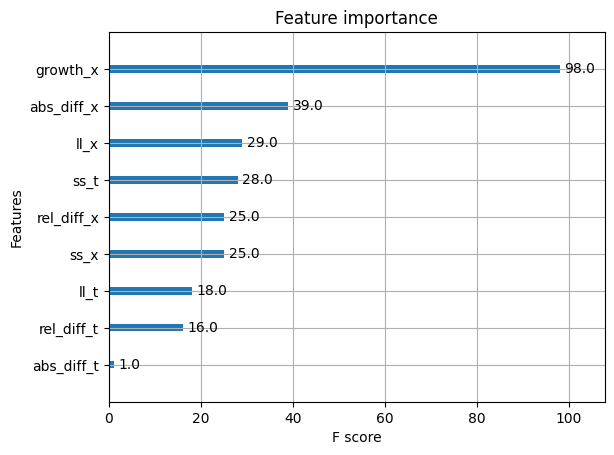

In [5]:
# Save the XGBoost model and check the feature importance
bst_model = grid_search.best_estimator_

with open('my_model.pkl', 'wb') as f:
    pickle.dump(bst_model, f)


heuristic_kf_dict = {'dstyle': 'heuristic',
            'ustyle': '--',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

xgb.plot_importance(bst_model)

In [6]:
# Plot a decision tree
# To check structure of different trees, change num_trees 
#xgb.to_graphviz(bst_model, num_trees=1)

In [7]:
# Fit data by distounted utility model and trade-off model
style_list = cross_valid.estimation.gen_style_list()
train_sample = data_prepare.train_sample

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [59:52<00:00, 16.33s/it]  


In [12]:
# Check if some of the fits fail to converge 
np.where(kf.success==False)

(array([], dtype=int64),)

In [13]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result = kf_result_df.drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(heuristic_kf_dict,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,heuristic,--,None,0.297701,0.297701,0.580450,0.702299,NaN
21,trade,power,"[0.801, 1.167, 8.033, 0.432, 0.087, 0.073]",0.203538,0.406876,0.595084,0.692727,0.236626
13,hbmd,power,"[7.507, 0.144, 0.173]",0.206008,0.412764,0.601453,0.691576,0.232034
19,quasihb_fc,power,"[0.997, 0.997, 1.065, 0.008, 0.006]",0.208440,0.417471,0.606193,0.685403,0.243938
17,quasihb,power,"[0.997, 0.997, 0.008, 0.007]",0.208532,0.417024,0.606492,0.687241,0.240460
7,expo2,power,"[0.969, 0.813, 0.648, 0.012, 0.01]",0.209698,0.419987,0.608994,0.685327,0.253611
3,attention_uni,power,"[1.423, 0.186, 0.362]",0.210643,0.421846,0.610948,0.679325,0.152402
11,hb2,power,"[0.079, 2.661, 0.017, 0.014]",0.210637,0.421841,0.611214,0.681571,0.251588
9,hb,power,"[0.01, 0.024, 0.021]",0.210859,0.422069,0.611717,0.681110,0.249051
5,expo,power,"[0.995, 0.013, 0.011]",0.211082,0.422421,0.612090,0.681110,0.249051


In [16]:
# Compare models: Out-of-sample performance
test_sample = data_prepare.test_sample
test_result = cross_valid.get_result_tab(kf_result_df,test_sample)

with open('my_model.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

heuristic_test_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,X_test=X_test,y_test=y_test)

test_result = pd.concat([test_result,pd.DataFrame(heuristic_test_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.199584,0.399751,0.586111,0.701781,0.290400
13,hbmd,power,0.203571,0.410726,0.595768,0.696351,0.236751
21,trade,power,0.201927,0.405074,0.591320,0.695048,0.249348
19,quasihb_fc,power,0.206754,0.411951,0.602772,0.693527,0.248262
17,quasihb,power,0.207318,0.422127,0.603657,0.693527,0.248262
5,expo,power,0.209738,0.427269,0.609090,0.689835,0.306255
15,hce,power,0.209680,0.428482,0.608991,0.685925,0.260209
9,hb,power,0.208980,0.423751,0.607495,0.685925,0.260209
3,attention_uni,power,0.210744,0.421783,0.611195,0.678323,0.157037
1,attention,power,0.215437,0.430909,0.623362,0.672893,0.141616


In [23]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_prepare = cross_valid.data_prepare(data=rda_sample)
rda_prepare.generate_features()
rda_sample = rda_prepare._data[features]
rda_sample[label] = heuristic_model.predict(rda_sample[features])

rda_result = cross_valid.get_result_tab(kf_result_df,rda_sample)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
21,trade,power,0.102988,0.304444,0.374555,0.957,0.228
13,hbmd,power,0.115094,0.321138,0.400894,0.950,0.203
19,quasihb_fc,power,0.113381,0.316242,0.395907,0.934,0.209
17,quasihb,power,0.125017,0.338001,0.425722,0.934,0.209
15,hce,power,0.133961,0.351174,0.446390,0.927,0.224
9,hb,power,0.128639,0.341746,0.433188,0.927,0.224
5,expo,power,0.132665,0.348959,0.443324,0.918,0.253
3,attention_uni,power,0.138541,0.349727,0.451288,0.878,0.137
1,attention,power,0.152987,0.368502,0.481647,0.859,0.126
20,trade,cara,0.151692,0.367740,0.484493,0.843,0.102


In [24]:
# Use the prediction value by magnitude-dependent hyperbolic (hbmd) with power utillity as the label
# Examine which model can explain the hbmd's prediction the best
target_kf_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
target_style = target_kf_row['style'].values[0]
target_params = target_kf_row['params'].values[0]

choice_prob = cross_valid.test_model(style=target_style,params=target_params,test_sample=rda_sample,output='predict_proba')
rda_sample[label] = (choice_prob >.5)

rda_result_2 = cross_valid.get_result_tab(kf_result_df,rda_sample).iloc[1:,:]
heuristic_rda_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,test_sample=rda_sample)
rda_result_2 = pd.concat([rda_result_2,pd.DataFrame(heuristic_rda_dict,index=[99])]).sort_values('accuracy',ascending=False)
rda_result_2

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.104826,0.302410,0.374942,0.957,0.245
13,hbmd,power,0.115726,0.321769,0.402108,0.943,0.203
9,hb,power,0.129027,0.342133,0.433830,0.928,0.224
15,hce,power,0.134387,0.351601,0.447140,0.928,0.224
19,quasihb_fc,power,0.113634,0.316495,0.396258,0.921,0.209
17,quasihb,power,0.125218,0.338202,0.426023,0.921,0.209
5,expo,power,0.133404,0.349697,0.444744,0.907,0.253
3,attention_uni,power,0.140181,0.351367,0.454956,0.879,0.137
1,attention,power,0.153357,0.368871,0.482425,0.864,0.126
20,trade,cara,0.148722,0.364771,0.478470,0.860,0.102


In [27]:
# Save the results
kf_result.to_csv("table/itch_result_kf.csv",index=False)
test_result.to_csv("table/itch_result_test.csv",index=False)
rda_result.to_csv("table/itch_result_rda.csv",index=False)

In [47]:
(itch_dt['ll_x']>5000).sum()/(itch_dt['ll_x']).shape[0]

0.10251063829787234